# Model Selection

## Importing Libraries

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# %load_ext nb_black

# Defaults
plt.rcParams["figure.figsize"] = (20.0, 10.0)
plt.rcParams.update({"font.size": 10, "figure.dpi": 120})
# pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")  # specify to ignore warning messages

## Data Handling

In [2]:
def preprocess(df):
    df = df.drop(["Lat", "Long"], axis=1)
    df = df.groupby(["Country/Region"], as_index=False).sum()
    df.loc[-1] = df.sum()
    df.loc[-1, "Country/Region"] = "Worldwide"
    countries = [
        "US",
        "Germany",
        "Spain",
        "United Kingdom",
        "France",
        "India",
        "Iran",
        "Italy",
        "Russia",
        "Turkey",
        #         "Worldwide",
    ]
    df = df.loc[df["Country/Region"].isin(countries)]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index("Country/Region")
    df.columns = pd.to_datetime(df.columns)
    df = df.T
    return df

In [3]:
confirmed_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
confirmed_df = preprocess(confirmed_df)
deaths_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
)
deaths_df = preprocess(deaths_df)
recovered_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
)
recovered_df = preprocess(recovered_df)

In [4]:
active_df = pd.DataFrame(confirmed_df - deaths_df - recovered_df)
#active_df.plot(figsize=(15, 5))
#plt.show()

In [5]:
#confirmed_df.plot(figsize=(15, 5))
#plt.show()

In [6]:
#deaths_df.plot(figsize=(15, 5))
#plt.show()

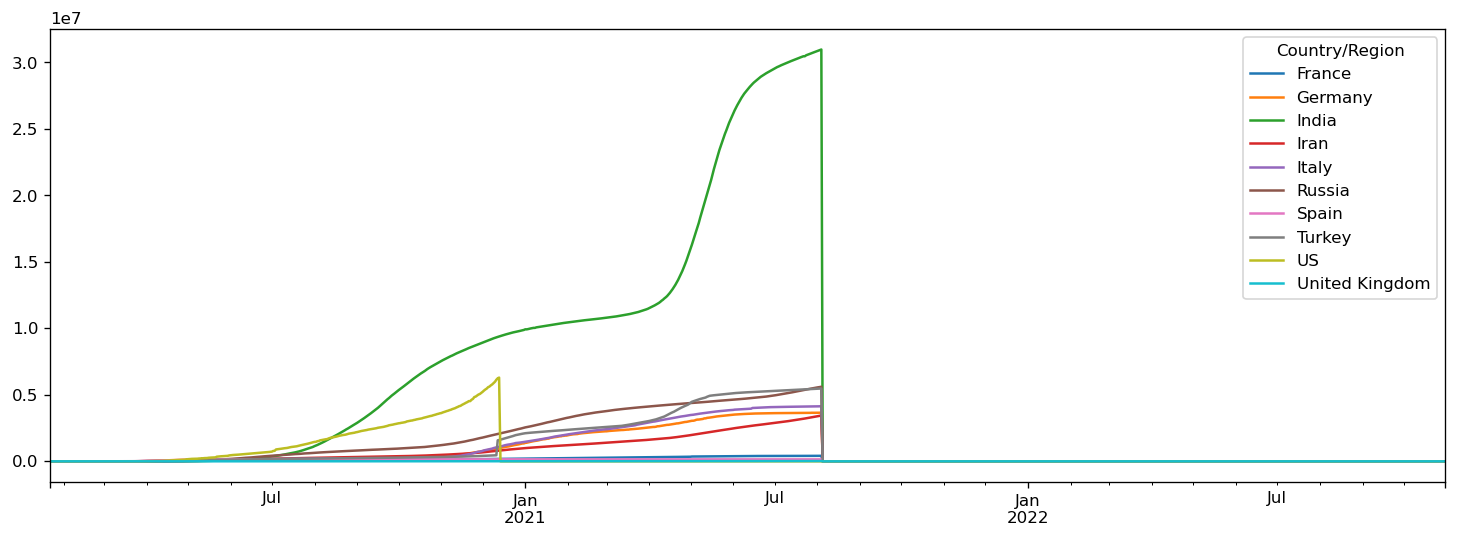

In [7]:
recovered_df.plot(figsize=(15, 5))
plt.show()

In [8]:
recovered_df['2021-05-07':'2021-05-31']

Country/Region,France,Germany,India,Iran,Italy,Russia,Spain,Turkey,US,United Kingdom
2021-05-07,369898,3142640,17930960,2074089,3572713,4429201,150376,4662328,0,14961
2021-05-08,371076,3160630,18317364,2092381,3590107,4437289,150376,4691224,0,15011
2021-05-09,371478,3187100,18671222,2109702,3604523,4444712,150376,4716918,0,15011
2021-05-10,372400,3188710,19027304,2127192,3619586,4451443,150376,4743871,0,15088
2021-05-11,373975,3231090,19382642,2144197,3636089,4458408,150376,4766124,0,15147
2021-05-12,375465,3233630,19734823,2162087,3655112,4466782,150376,4801291,0,15158
2021-05-13,376532,3268190,20079599,2179890,3669407,4475999,150376,4856763,0,15201
2021-05-14,377338,3284300,20432898,2196197,3683189,4485592,150376,4894024,0,15214
2021-05-15,378643,3292700,20795335,2210851,3696481,4495406,150376,4932838,0,15254
2021-05-16,378958,3306260,21174076,2226122,3706084,4503945,150376,4947256,0,15258


### Train test split

In [9]:
#active_train = active_df["2020-01-22":"2021-04-22"]
active_train = active_df["2020-02-04":"2021-08-04"]
active_test = active_df["2021-04-23":"2021-04-08"]
confirmed_train = confirmed_df["2020-01-22":"2021-04-22"]
confirmed_test = confirmed_df["2021-04-23":"2021-04-08"]
active_train.to_excel('Active.xlsx')

## Model Selection

### Determining order of differencing (d)

In [10]:
# Original Series
country = "India"
df = pd.DataFrame((active_train[country].to_numpy()), columns = {'cases'})
df = df.transform('sqrt')

In [11]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.358289
p-value: 0.153857
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


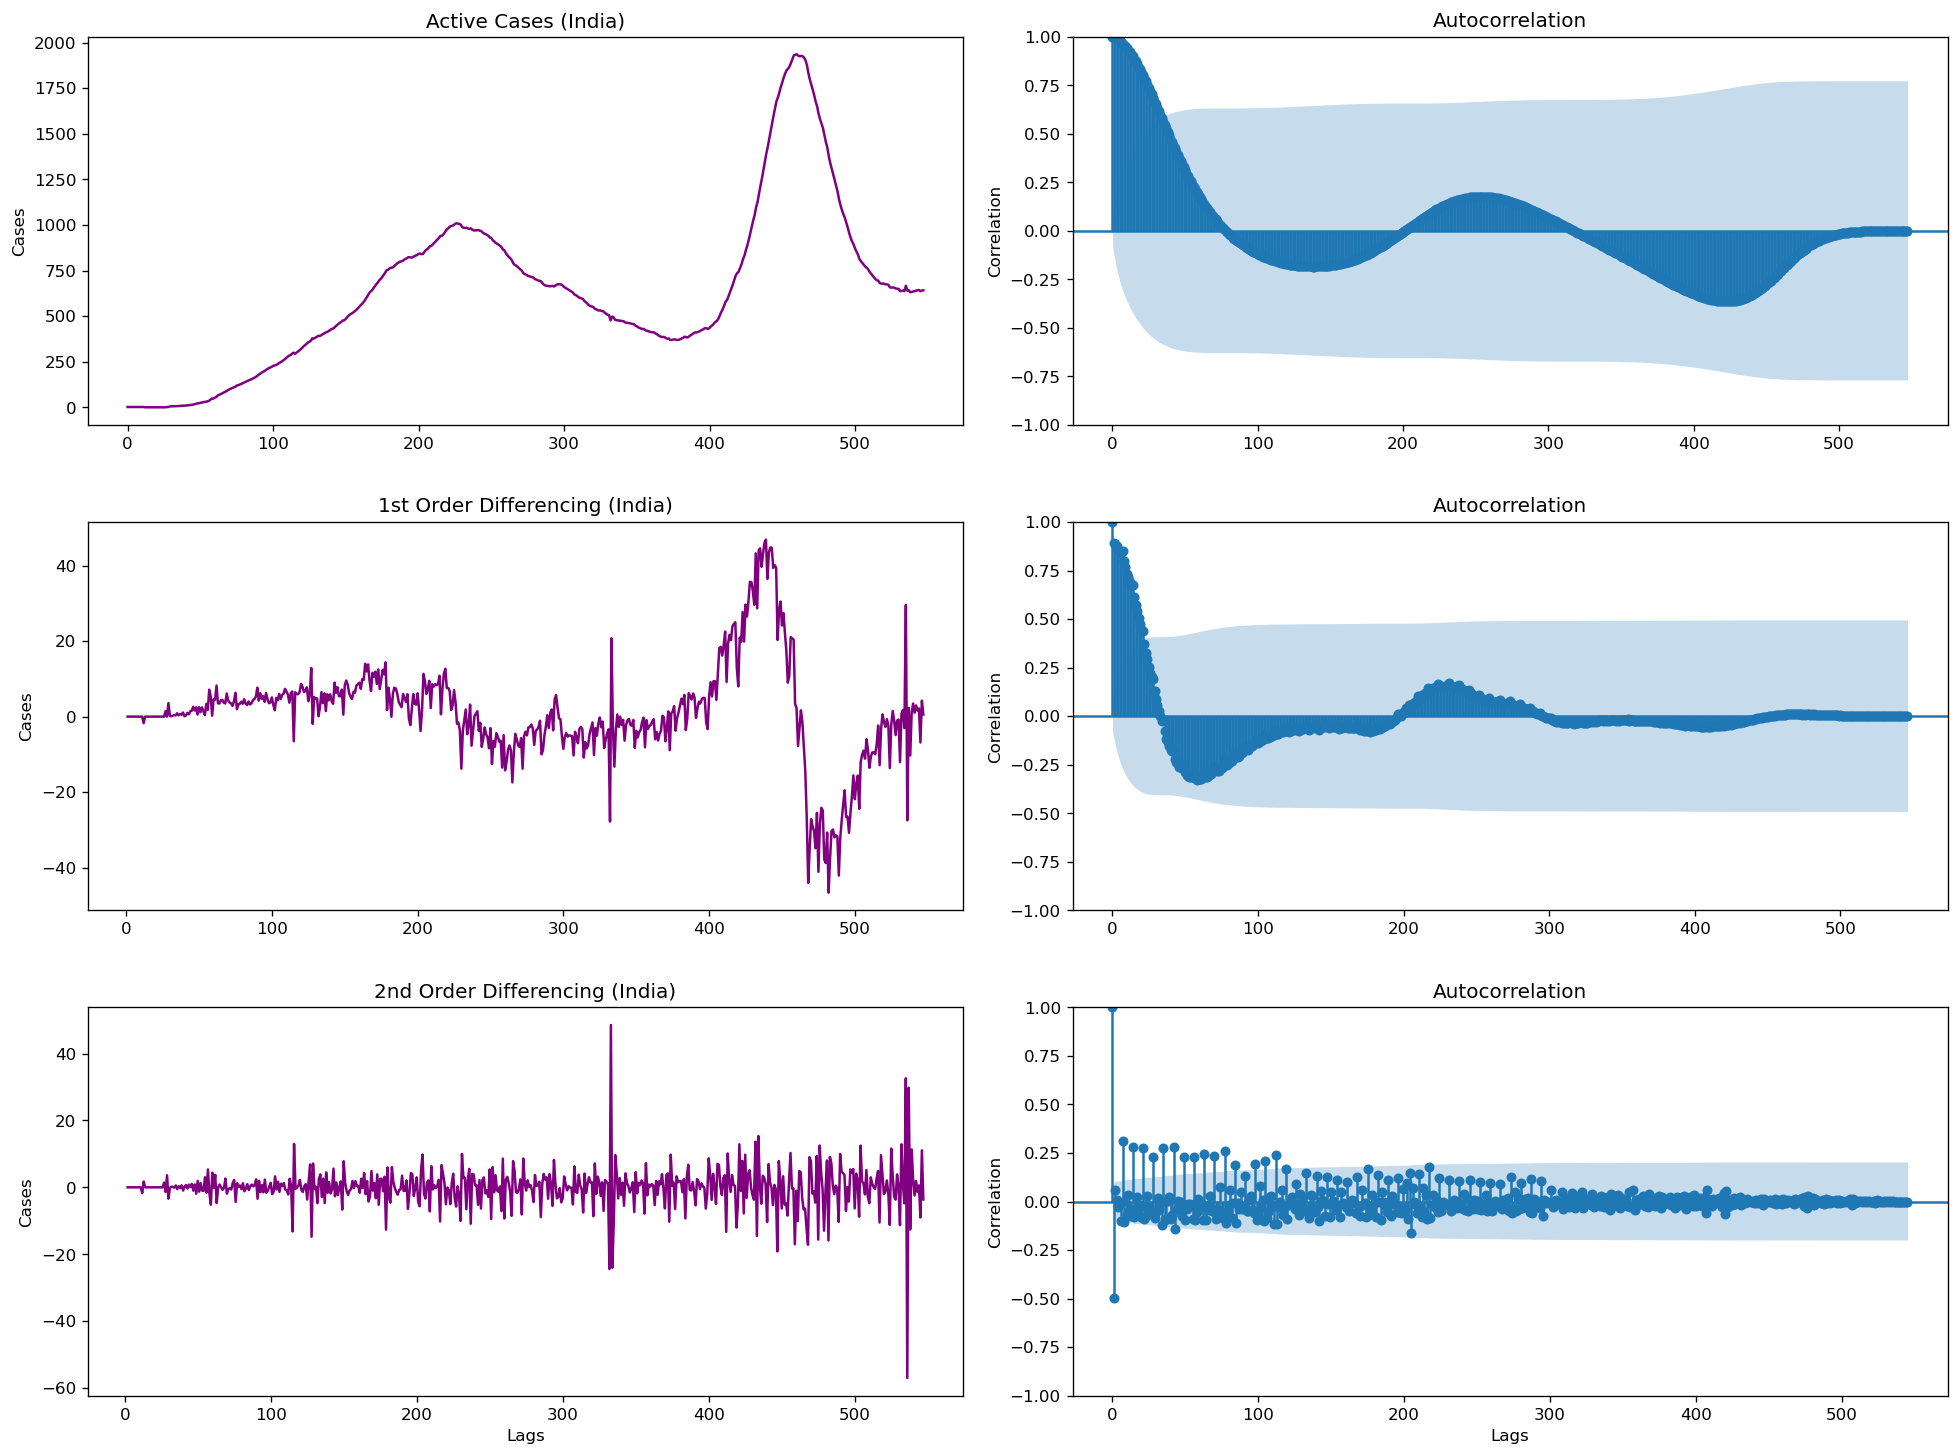

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=0.250, wspace=0.125)
axes[0, 0].plot(df, "purple")
axes[0, 0].set(title=f"Active Cases ({country})", ylabel="Cases")
plot_acf(df, ax=axes[0, 1], lags=df.shape[0] - 1)
axes[0, 1].set(ylabel="Correlation")

# 1st Differencing
axes[1, 0].plot(df.diff(), "purple")
axes[1, 0].set(title=f"1st Order Differencing ({country})", ylabel="Cases")
plot_acf(df.diff().dropna(), ax=axes[1, 1], lags=df.shape[0] - 2)
axes[1, 1].set(ylabel="Correlation")


# 2nd Differencing
axes[2, 0].plot(df.diff().diff(), "purple")
axes[2, 0].set(
    xlabel="Lags", ylabel="Cases", title=f"2nd Order Differencing ({country})"
)
axes[2, 1].set_xlabel("Lags")
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1], lags=df.shape[0] - 3)
axes[2, 1].set(ylabel="Correlation")

fig.savefig("Graphs/1.acf_plots.jpg")
plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the second differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.
$$d = 1 $$

### Determining order of Auto-Regression (p)

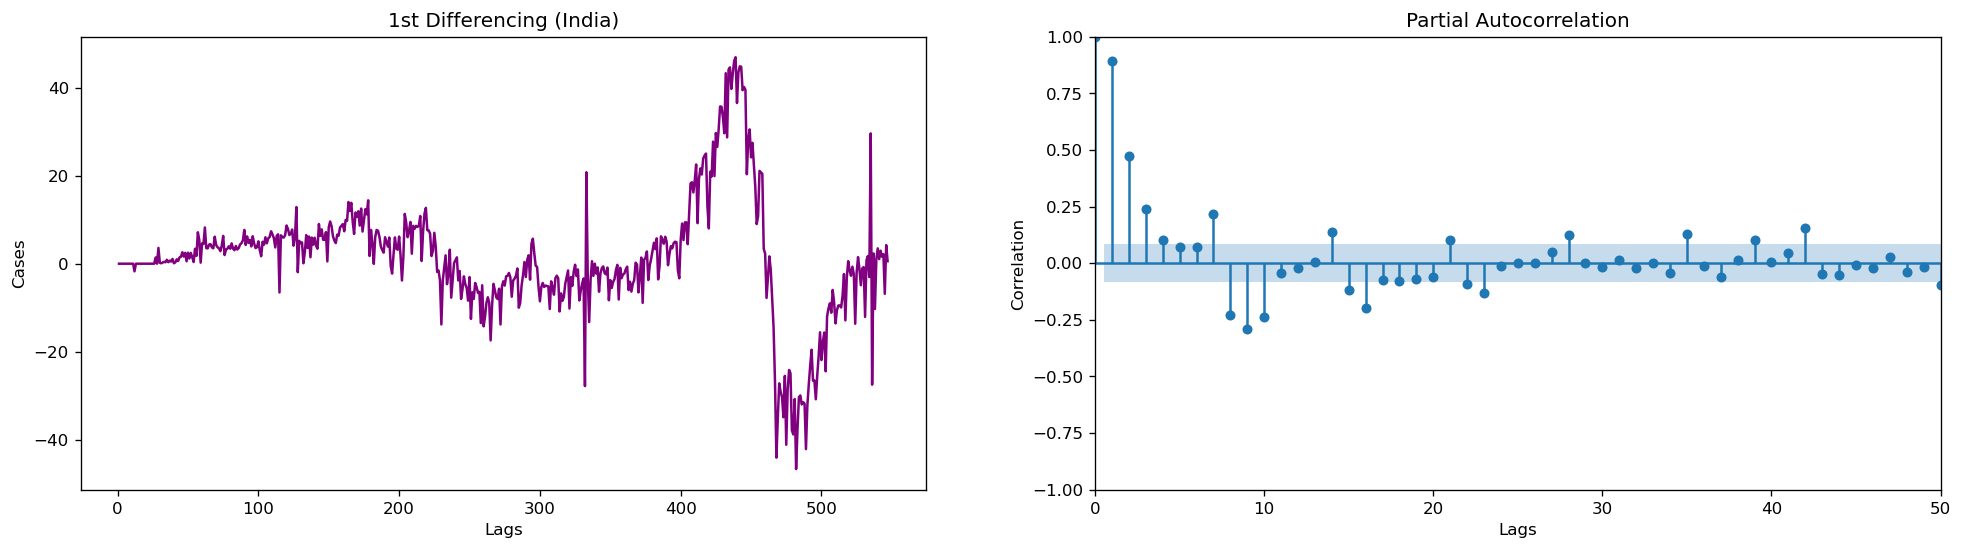

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(df.diff(), "purple")
ax1.set(title=f"1st Differencing ({country})", xlabel="Lags", ylabel="Cases")
plot_pacf(df.diff().dropna(), ax=ax2, lags=272)
ax2.set(xlabel="Lags", ylabel="Correlation", ylim=(-1, 1), xlim=(0, 50))
fig.savefig("Graphs/2.pacf_plots.jpg")
plt.show()

It can observed that the PACF lag 1, 2 and 3 are quite significant since they are well above the significance limit, the blue region.
So we will use:
$$p \in \{1, 2, 3\}$$

### Determining order of Moving Average (q)

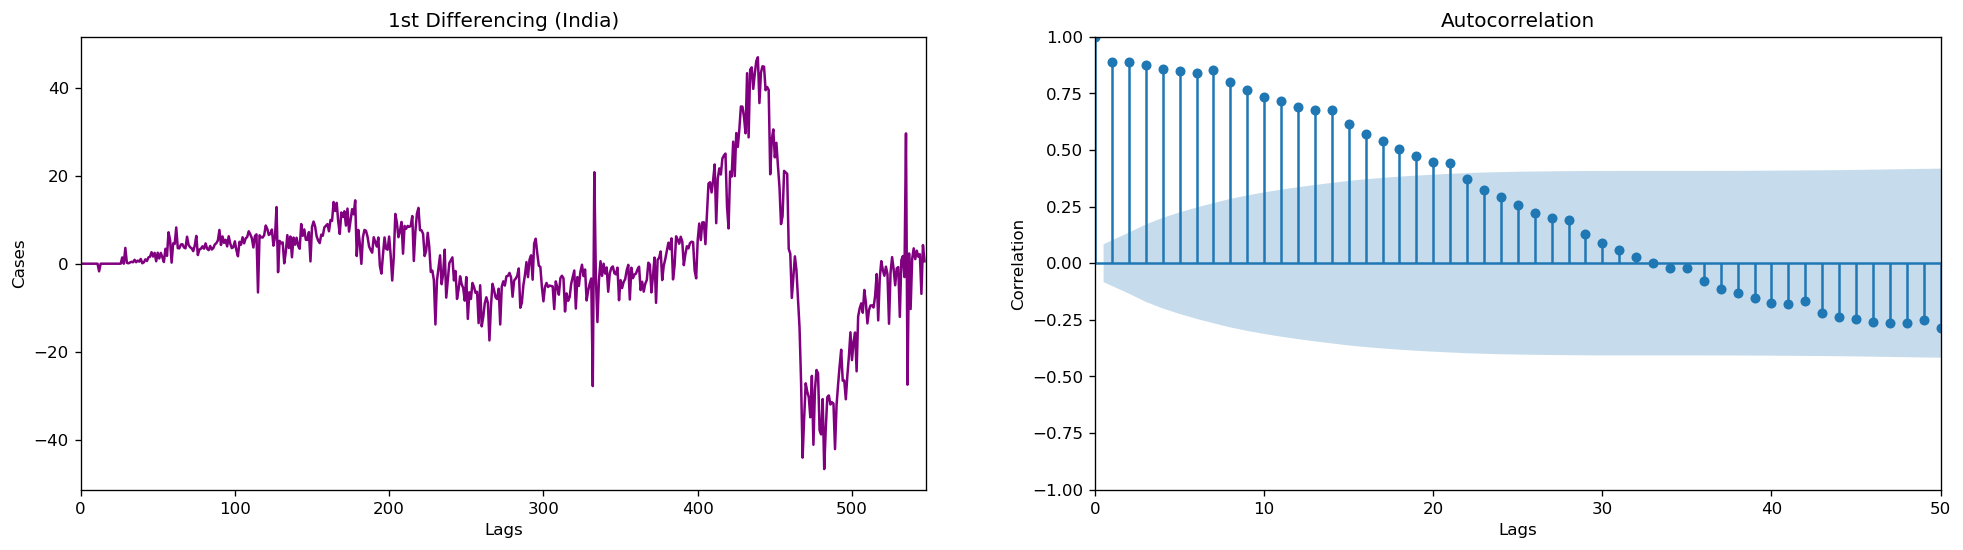

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(df.diff(), "purple")
axes[0].set(
    title=f"1st Differencing ({country})",
    xlabel="Lags",
    ylabel="Cases",
    xlim=(0, df.shape[0]),
)
plot_acf(df.diff().dropna(), ax=axes[1], lags=df.shape[0] - 2)
axes[1].set(ylim=(-1, 1), xlim=(0, 50), xlabel="Lags", ylabel="Correlation")

fig.savefig("Graphs/3.acf_plots.jpg")
plt.show()

We can see that upto `lags` = 9, the correlation is above the significance range and so we can conclude that: $$q \in [1, 9]$$

In [15]:
# Define the p, d, q parameters
p = range(1, 4)
d = 1
q = range(1, 10)

In [16]:
import pmdarima as pm

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4051.587, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8849.795, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3383.838, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3381.319, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3351.962, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3381.229, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3383.198, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3351.925, Time=0.62 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3371.711, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3371.759, Time=0

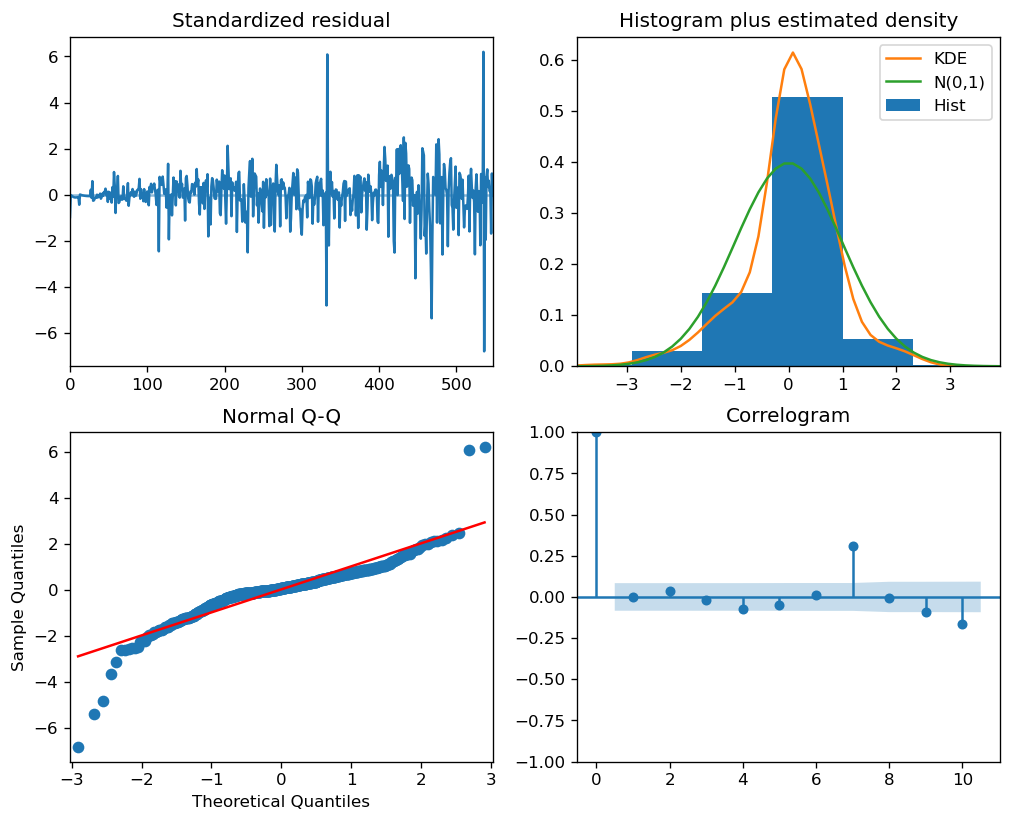

In [17]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  548
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1668.664
Date:                Fri, 02 Dec 2022   AIC                           3351.328
Time:                        22:02:11   BIC                           3381.472
Sample:                             0   HQIC                          3363.110
                                - 548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        634.5839    190.767      3.326      0.001     260.687    1008.481
ar.L1          2.9421      0.024    121.731      0.000       2.895       2.989
ar.L2         -2.8877      0.048    -59.979      0.0

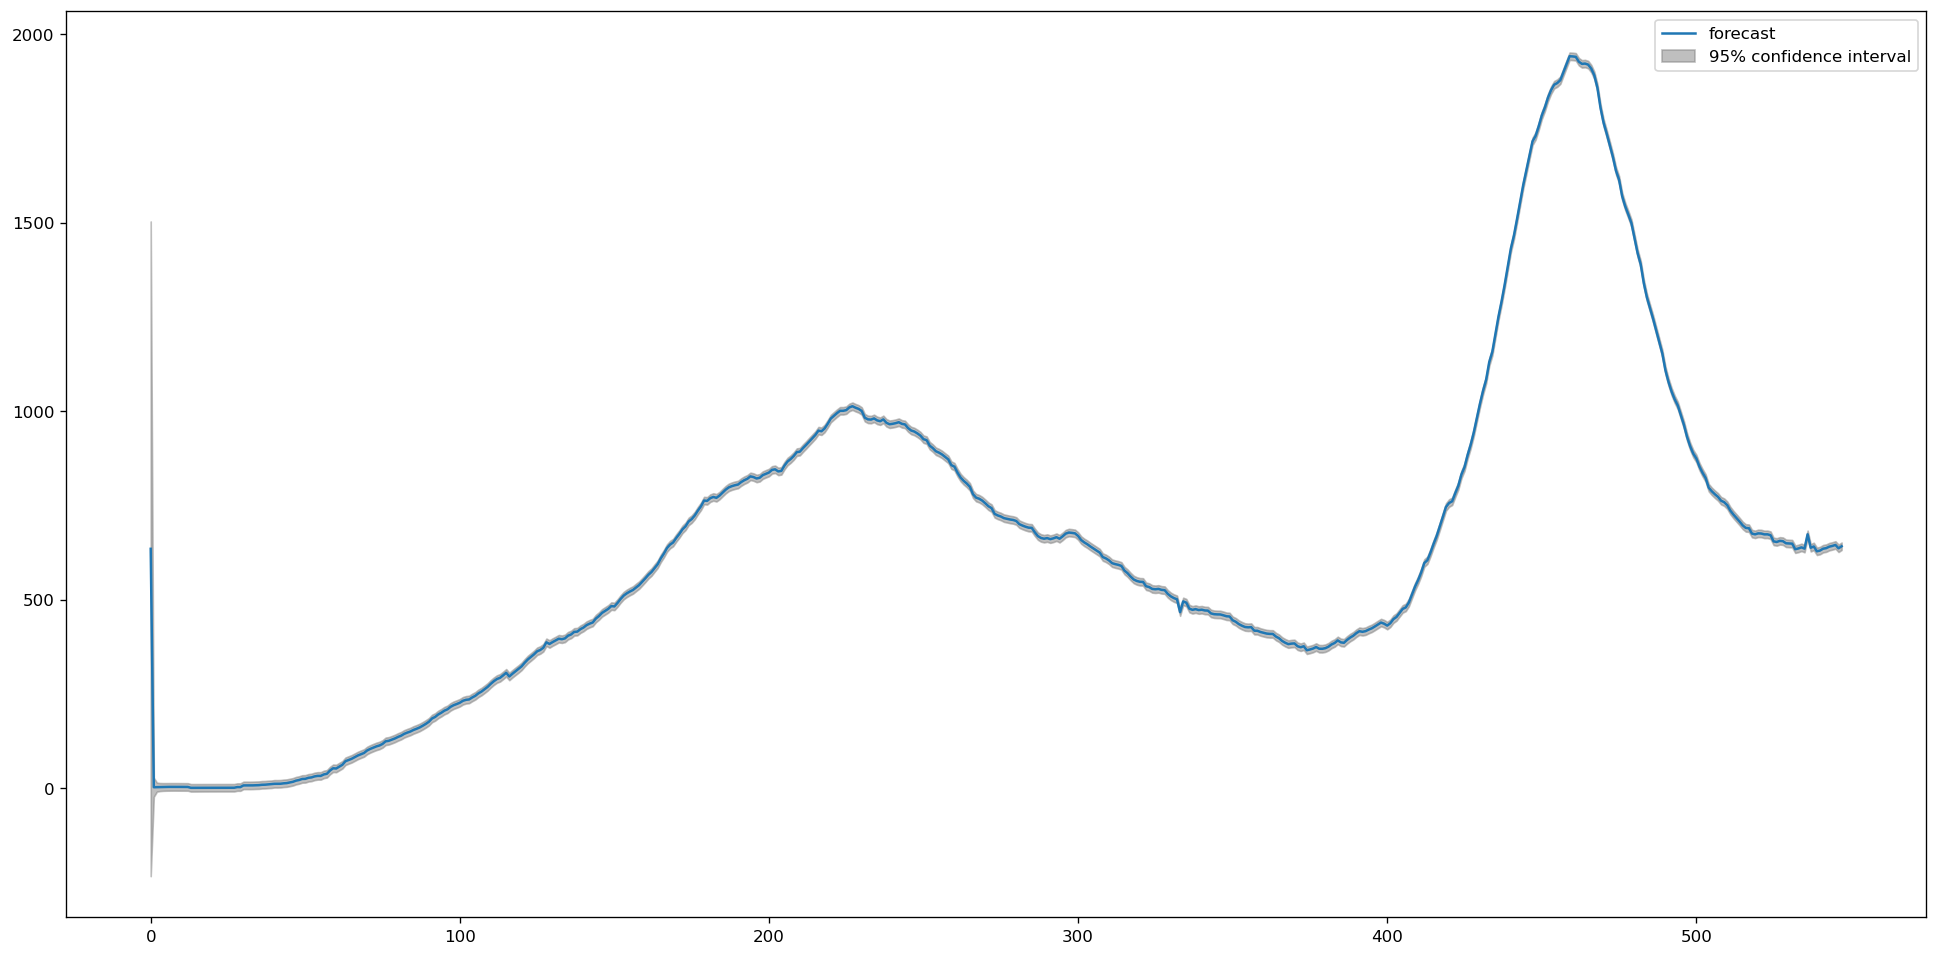

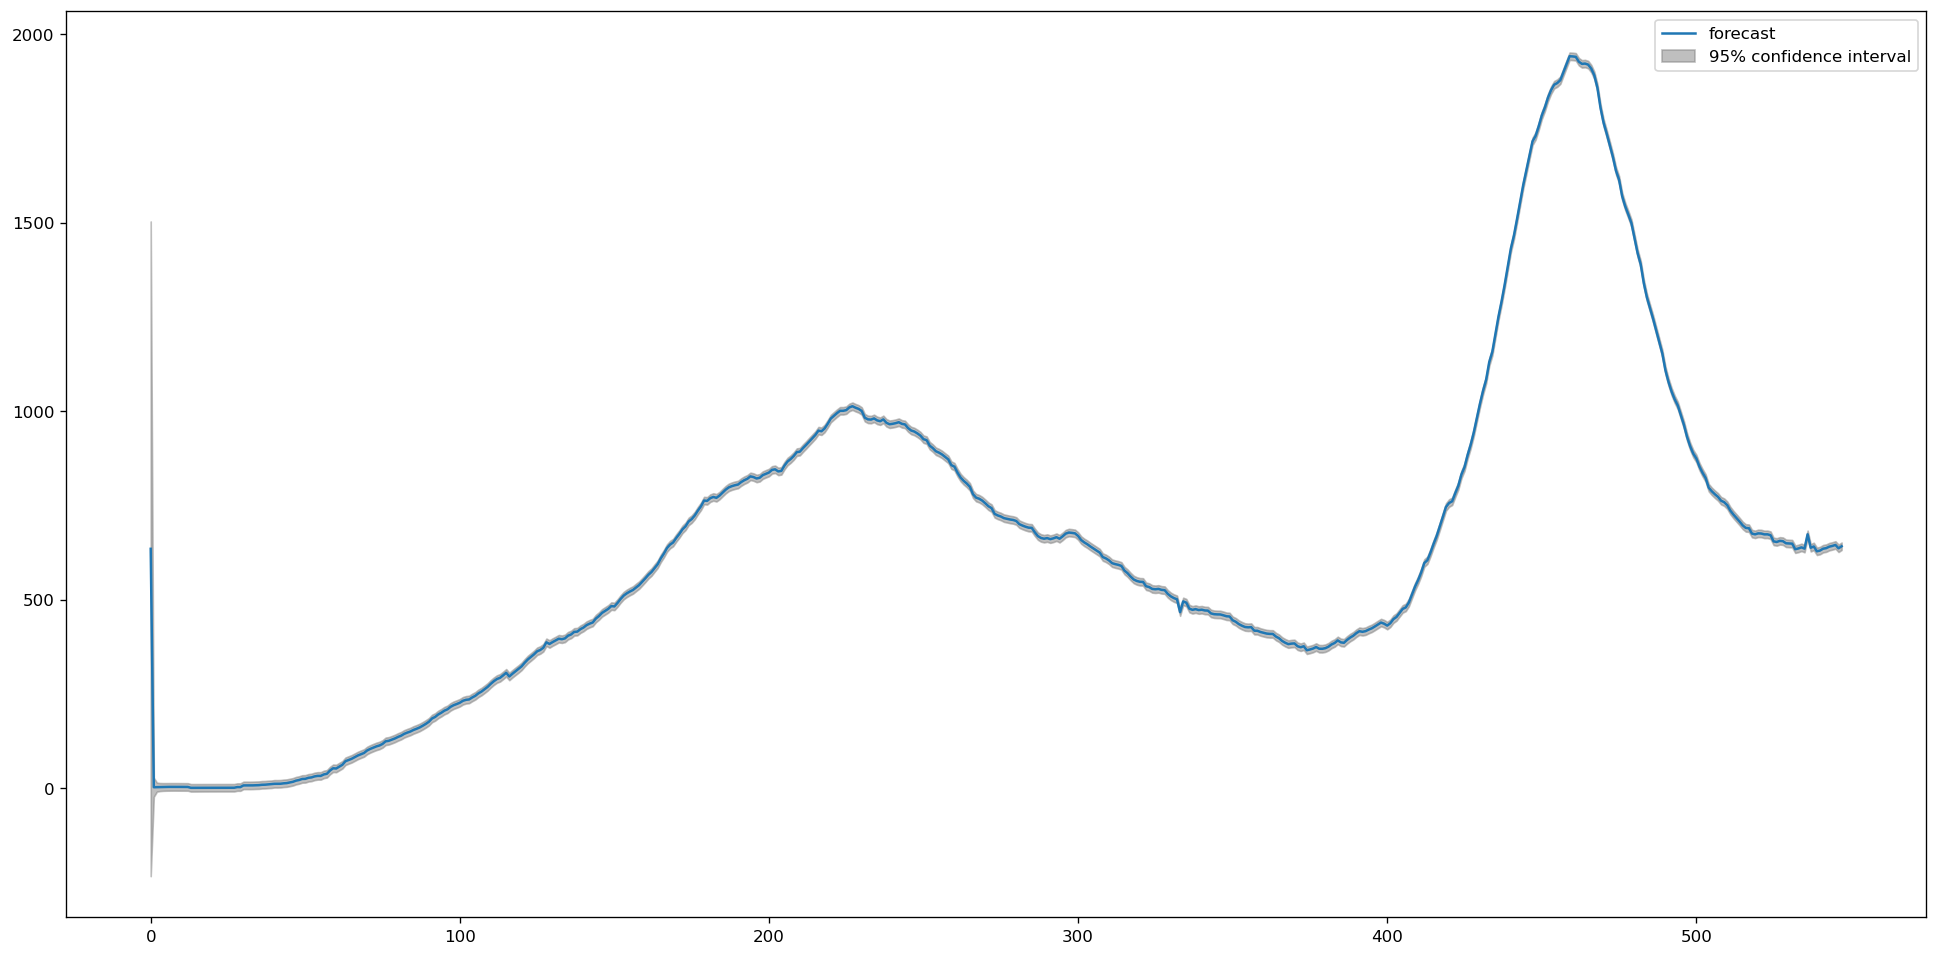

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
model = ARIMA(df, order=(3,0,2))
model_fit = model.fit()
print(model_fit.summary())
plot_predict(model_fit)

In [19]:
model = ARIMA(df, order=(2, 0, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc = fitted.forecast(100, alpha=0.05)  # 95% conf
print(fc.shape)
#Make as pandas series
fc_series = fc.to_numpy().reshape(100, -1)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

# # Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
# plt.plot(test, label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  548
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1681.740
Date:                Fri, 02 Dec 2022   AIC                           3373.481
Time:                        22:02:12   BIC                           3395.012
Sample:                             0   HQIC                          3381.896
                                - 548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        634.7525    105.868      5.996      0.000     427.256     842.249
ar.L1          1.9861      0.005    367.572      0.000       1.976       1.997
ar.L2         -0.9869      0.005   -181.735      0.0

In [20]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

# print (fc_series.reshape(100, -1).shape, df[-100:].to_numpy().shape)

forecast_accuracy(fc_series, df[-100:].to_numpy())


{'mape': 0.31896131732658334,
 'me': -489.2758385974741,
 'mae': 489.84696891403553,
 'mpe': -0.31806094758210024,
 'rmse': 695.4824735754537,
 'corr': nan,
 'minmax': 0.31895784973851693}